In [188]:
import os
import pandas as pd 
import pickle
import numpy as np
import re
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,Dropout,add,BatchNormalization,Embedding,LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import glob as glob
import seaborn as sns

In [189]:
img_path='/kaggle/input/flickr8k/Images'
caption_path='/kaggle/input/flickr8k/captions.txt'

In [191]:
data=pd.read_csv(caption_path)
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


# Text Preprocessing

In [200]:
def clean_text (text):
  text= text.lower()
  # Removing punctuation marks
  text = re.sub(r'[^\w\s]', '', text)
    
    # Removing numbers
  text = re.sub(r'\d+', '', text)
    
    # Removing extra whitespace
  text = re.sub(r'\s+', ' ', text).strip()
  text = " ".join([word for word in text.split() if len(word) > 1])
  return text

In [201]:
cleaned_data=data['caption'].apply(clean_text)
for i in cleaned_data.head():
    print(i)

child in pink dress is climbing up set of stairs in an entry way
girl going into wooden building
little girl climbing into wooden playhouse
little girl climbing the stairs to her playhouse
little girl in pink dress going into wooden cabin


In [203]:
caption_IDs=[]
for c in range(len(cleaned_data)):
    item=str(data['image'][c])+'\t'+'start '+cleaned_data[c]+' end\n'
    caption_IDs.append(item)

In [204]:
caption_IDs[:10]

['1000268201_693b08cb0e.jpg\tstart child in pink dress is climbing up set of stairs in an entry way end\n',
 '1000268201_693b08cb0e.jpg\tstart girl going into wooden building end\n',
 '1000268201_693b08cb0e.jpg\tstart little girl climbing into wooden playhouse end\n',
 '1000268201_693b08cb0e.jpg\tstart little girl climbing the stairs to her playhouse end\n',
 '1000268201_693b08cb0e.jpg\tstart little girl in pink dress going into wooden cabin end\n',
 '1001773457_577c3a7d70.jpg\tstart black dog and spotted dog are fighting end\n',
 '1001773457_577c3a7d70.jpg\tstart black dog and tricolored dog playing with each other on the road end\n',
 '1001773457_577c3a7d70.jpg\tstart black dog and white dog with brown spots are staring at each other in the street end\n',
 '1001773457_577c3a7d70.jpg\tstart two dogs of different breeds looking at each other on the road end\n',
 '1001773457_577c3a7d70.jpg\tstart two dogs on pavement moving toward each other end\n']

In [205]:
data['caption']=caption_IDs

In [ ]:
def visualaization(data, num_of_images):
    # We use dictionaries to access captions of each image by its ID
    captions_dictionary = {}
    for item in data[100:100+(num_of_images)*5]:
        image_id, caption = item.split('\t')
        if image_id not in captions_dictionary:
            captions_dictionary[image_id] = []
        captions_dictionary[image_id].append(caption)
    else:
        list_captions = [x for x in captions_dictionary.items()]
    
    count = 1
    fig = plt.figure(figsize=(10,20))
    for filename in list(captions_dictionary.keys()):
        captions = captions_dictionary[filename]
        image_load = load_img(images_directory+filename, target_size=(199,199,3))

        ax = fig.add_subplot(num_of_images,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(num_of_images,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(captions))
        for i, caption in enumerate(captions):
            ax.text(0,i,caption,fontsize=20)
        count += 1
    plt.show()
    
visualaization(captions_IDs, 5)

# Tokenization & Splitting

In [206]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(cleaned_data.to_list())
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in cleaned_data)
max_length

32

In [207]:
all_images=os.listdir(img_path)
len(all_images)

8091

In [208]:
train_images, test_images = train_test_split(all_images, test_size=0.15, random_state=42)

In [269]:
train_caption, test_caption =[],[]
for c in caption_IDs:
    img_id,img_cap=c.split('\t')
    if img_id in train_images:
        train_caption.append(c)
    elif img_id in test_images:
        test_caption.append(c)
    else:
        print(c)

# Extracting Image features

In [221]:
inceptionV3_model=InceptionV3(weights='imagenet',include_top=False,input_shape=(299, 299, 3))
inceptionV3_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 299, 299, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_94 (Conv2D)        │ (None, 149, 149, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_100   │ (None, 149, 149, 32)   │             96 │ conv2d_94[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_94             │ (None, 149, 149, 32)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_95 (Conv2D)        │ (None, 147, 147, 32)   │          9,216 │ activation_94[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_101   │ (None, 147, 147, 32)   │             96 │ conv2d_95[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_95             │ (None, 147, 147, 32)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_96 (Conv2D)        │ (None, 147, 147, 64)   │         18,432 │ activation_95[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_102   │ (None, 147, 147, 64)   │            192 │ conv2d_96[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_96             │ (None, 147, 147, 64)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 73, 73, 64)     │              0 │ activation_96[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_97 (Conv2D)        │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_103   │ (None, 73, 73, 80)     │            240 │ conv2d_97[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_97             │ (None, 73, 73, 80)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)   

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [222]:
# The second-to-last layer typically contains high-level features learned by the model.
inceptionV3_model = Model(inputs=inceptionV3_model.inputs, outputs=inceptionV3_model.layers[-2].output)

In [223]:
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(img_path, image), target_size=(299, 299))
    img = img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    feature = inceptionV3_model.predict(img, verbose=0)
    features[image] = feature.flatten()  # Flatten the features

  0%|          | 0/8091 [00:00<?, ?it/s]

In [224]:
features

{'1000268201_693b08cb0e.jpg': array([0.6324837, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ], dtype=float32),
 '1001773457_577c3a7d70.jpg': array([0.       , 1.6551027, 0.5713551, ..., 0.       , 0.7844612,
        0.       ], dtype=float32),
 '1002674143_1b742ab4b8.jpg': array([0.        , 0.02301091, 0.9991849 , ..., 1.3925618 , 1.3521137 ,
        0.        ], dtype=float32),
 '1003163366_44323f5815.jpg': array([0.25520015, 1.712893  , 0.5919306 , ..., 0.60145223, 0.3736361 ,
        0.86054766], dtype=float32),
 '1007129816_e794419615.jpg': array([0.        , 0.22039172, 0.        , ..., 0.        , 0.        ,
        0.        ], dtype=float32),
 '1007320043_627395c3d8.jpg': array([0.       , 1.0103511, 0.       , ..., 0.       , 1.0076442,
        0.3997109], dtype=float32),
 '1009434119_febe49276a.jpg': array([0.        , 0.77905566, 0.        , ..., 0.        , 0.        ,
        0.        ], dtype=float32),
 '1012212859_01547e3f17.jpg': array([0.      

In [225]:
train_image_features, test_image_features = {}, {} # A Dictionary to store image features with their corresponding IDs       
for id_ in features:
    if id_ in train_images:
        train_image_features[id_] = features[id_].flatten()  # Flattening the features    
    elif id_ in test_images:
        test_image_features[id_] = features[id_].flatten()  # Flattening the features
    else:
        print('Unknown image ID !')
# get the feature matrix for every image and store them in these dictionaries train_image_features, test_image_features

# Data Setup

In [272]:
def data_generator(captions, image_features, tokenizer, max_caption_len, batch_size):
    num_samples = len(captions)
    image_ids = list(image_features.keys())
    
    while True:
        np.random.shuffle(image_ids)
        
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            x_images, x_captions, y = [], [], []
            for caption in captions[start:end]:
                image_id = caption.split('\t')[0]  # Assuming your DataFrame has 'image' column
                caption_text = caption.split('\t')[1]  # Assuming 'cleaned_caption' is the processed caption text column
                
                seq = tokenizer.texts_to_sequences([caption_text])[0]
                
                for i in range(1, len(seq)):
                    in_seq, out_word = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_len)[0]
                    out_word = to_categorical([out_word], num_classes=vocab_size)[0]
                    
                    x_images.append(image_features[image_id])  # Already flattened
                    x_captions.append(in_seq)
                    y.append(out_word)
            
            yield (np.array(x_images), np.array(x_captions)), np.array(y)

In [273]:
max_captions_len=max(len(line.split()) for line in cleaned_data)+1
max_captions_len

33

In [274]:
cnn_output_dim = inceptionV3_model.output_shape[1] * inceptionV3_model.output_shape[2] * inceptionV3_model.output_shape[3]
cnn_output_dim

12288

In [287]:
batch_train=64
batch_test=64

In [276]:
train_data_generator = data_generator(train_caption, train_image_features, tokenizer, max_captions_len, batch_train)
test_data_generator = data_generator(test_caption, test_image_features, tokenizer, max_captions_len, batch_test)


# Build The Model

In [294]:
def build_model(vocab_size, max_caption_len, cnn_output_dim):
    # Encoder
    Input_image = Input(shape=(cnn_output_dim,), name='Feature_Input')  # Flattened shape
    x = BatchNormalization()(Input_image)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    
    # Decoder
    Input_cation = Input(shape=(max_caption_len,), name='Caption_Input')
    y = Embedding(input_dim=vocab_size, output_dim=256, mask_zero=True)(Input_cation)
    y = LSTM(256)(y)
    
    # Output
    decoder = add([x, y])
    decoder = Dense(256, activation='relu')(decoder)
    output = Dense(vocab_size, activation='softmax', name='output_layer')(decoder)
    
    # Create the model
    model = Model(inputs=[Input_image, Input_cation], outputs=output)
    return model

In [295]:
model=build_model(vocab_size,max_captions_len,cnn_output_dim)
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Feature_Input             │ (None, 12288)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_202   │ (None, 12288)          │         49,152 │ Feature_Input[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Caption_Input             │ (None, 33)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 256)            │      3,145,984 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_7 (Embedding)   │ (None, 33, 256)        │      2,244,096 │ Caption_Input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_7 (NotEqual)    │ (None, 33)             │              0 │ Caption_Input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_203   │ (None, 256)            │          1,024 │ dense_14[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_7 (LSTM)             │ (None, 256)            │        525,312 │ embedding_7[0][0],     │
│                           │                        │                │ not_equal_7[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_7 (Add)               │ (None, 256)            │              0 │ batch_normalization_2… │
│                           │                        │                │ lstm_7[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 256)            │         65,792 │ add_7[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_layer (Dense)      │ (None, 8766)           │      2,252,862 │ dense_15[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 8,284,222 (31.60 MB)

 Trainable params: 8,259,134 (31.51 MB)

 Non-trainable params: 25,088 (98.00 KB)

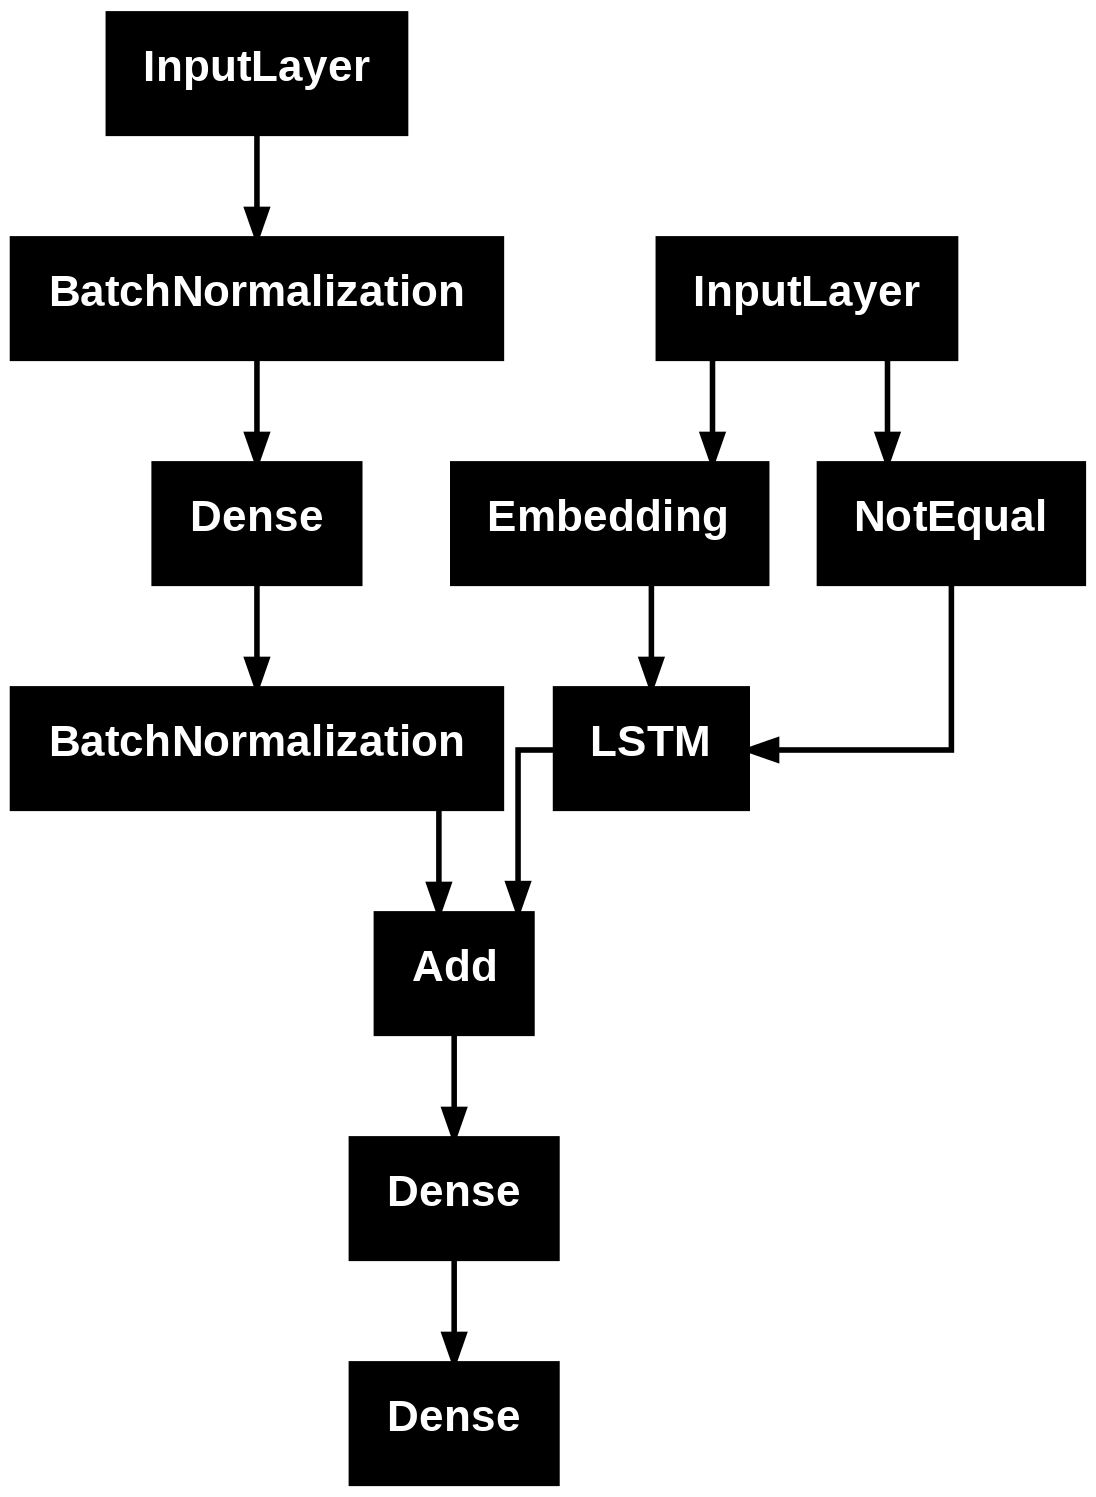

In [296]:
plot_model(model)

In [297]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.1, clipnorm=1.0))

# Training

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

def lr_scheduler(epoch, lr):
    return float(lr * tf.math.exp(-0.6))

    
lr_schedul = LearningRateScheduler(lr_scheduler)

steps_per_epoch = len(train) // batch_train
validation_steps = len(test) // batch_test

history = model.fit(
    train_data_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_data_generator,
    validation_steps=validation_steps,
    epochs=15,
    callbacks=[early_stopping, lr_schedul]
)


Epoch 1/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 555s 5s/step - loss: 6.4640 - val_loss: 4.9123 - learning_rate: 0.0549
Epoch 2/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 536s 5s/step - loss: 4.8345 - val_loss: 4.7899 - learning_rate: 0.0301
Epoch 3/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 540s 5s/step - loss: 4.4630 - val_loss: 4.5336 - learning_rate: 0.0165
Epoch 4/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 540s 5s/step - loss: 4.3137 - val_loss: 4.4567 - learning_rate: 0.0091
Epoch 5/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 543s 5s/step - loss: 4.2220 - val_loss: 4.4484 - learning_rate: 0.0050
Epoch 6/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 534s 5s/step - loss: 4.1722 - val_loss: 4.3680 - learning_rate: 0.0027
Epoch 7/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 534s 5s/step - loss: 4.1616 - val_loss: 4.3858 - learning_rate: 0.0015
Epoch 8/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 544s 5s/step - loss: 4.1204 - val_loss: 4.3420 - learning_rate: 8.2297e-04
Epoch 9/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 543s 5s/step - loss: 4.0383 - val_loss: 4.4158 - learning_rate: 4.51

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], color='green', linestyle='-', marker='o', markersize=5, label='Train Loss')
plt.plot(history.history['val_loss'], color='red', linestyle='--', marker='x', markersize=5, label='Validation Loss')

plt.title('Model Loss Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)

plt.legend(loc='upper left', fontsize=12)

plt.xlim(0, len(history.history['loss']) - 1)

plt.tight_layout()
plt.show()
